# Part 6 - Google Trends data

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

In this notebook I will describe my code to download data from Google trends 
as well as code to pull *keyword suggestions" based on some *seed* keywords.

I start in the usual way I do with all my notebooks with
* imports
* print version for Python and non standar modules

This boilerplate code is evolving and hopefully getting better

In [1]:
import os
import sys
import datetime
import inspect
import pandas as pd
import plotnine as pn
import pytrends as pt
from pytrends.request import TrendReq

In [2]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    mname = name
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        mname = name
        if hasattr(mod, "__path__"):
            mname = os.path.split(mod.__path__[0])[1]
        print("version {1} of {0} as {2} ".format(mname, name, mod.__version__))
    elif hasattr(mod, "__file__") and "site-packages" in mod.__file__:
        print("No __version__ for {0} as {1}".format(mname, name))
del mod
del name

version 3.9.2 of Python
version pd of pandas as 1.2.3 
version pn of plotnine as 0.7.1 
No __version__ for pt as pt


## Pytrends api
I'm new to pytrends but I'll make a go of using it.

Seems like the steps are
* create a *TrendReq* object which is usually called *pytrends*.
* configure the TrendReq object, called pytrends, by calling *build_payload* with pytrends with parameters for 
  - a keyword list
  - a timeframe
  - a geography reference
* call *interest_over_time* to get the data, returns a dataframe
 
It will be useful to wrap some of the code that sets up the paramaters for  ***build_payload*** into a function

I'll call the function *set_payload*

In [3]:
def set_payload(trend_req, kw_list, nweeks=100, geo='US', cat=60, grop=''):
    end_date = datetime.date.today()
    start_date = datetime.date.today() - datetime.timedelta(weeks=nweeks)
    timeframe = start_date.strftime("%Y-%m-%d") + " " + end_date.strftime("%Y-%m-%d")  
    trend_req.build_payload(kw_list, cat=cat, timeframe=timeframe, geo=geo, gprop=grop)    
    return trend_req

In [4]:
tr = TrendReq(hl='en-US', tz=360)
tr = set_payload(trend_req=tr, kw_list=['work'], cat=60, nweeks=20, geo='US', grop='')
df = tr.interest_over_time()
print(df.head(2))
print(df.tail(2))

            work  isPartial
date                       
2020-12-15    78      False
2020-12-16    78      False
            work  isPartial
date                       
2021-04-30    74      False
2021-05-01    41      False


I don't know what *isPartial* means yet.  The module documentation does not say much about it.
I read somewere *You can ignore isPartial for now: that field lets you know if the data point is complete for that particular date*, so I plan to remove an ignore it.
Now let's try with more keywords and plot the results

<AxesSubplot:xlabel='date'>

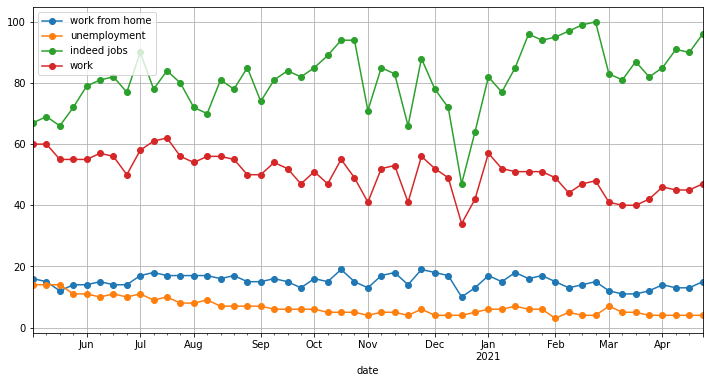

In [5]:
kw_list = [  "work from home",  "unemployment", "indeed jobs", "work"]
nweeks = 52
tr = set_payload(trend_req=tr, kw_list=kw_list, nweeks=nweeks, )
df = tr.interest_over_time().drop("isPartial", axis=1)
df.plot(figsize=[12,6], grid=True, marker='o')

Notes
* the resulting data is weekly. I have read that that is the standard when the time span is over 90 days.
* There is a *get_daily_data* method available in the pytrends module but I ok with weekly for now.


## Getting More keywords
OK, so far so good.  Maybe using more keywords would give us better preictor variables, but what other keywords might be useful.  The trend_requst object gives 2 methods that seem like they might help here
* relate_queries
* suggestions
I'm not sure the difference but for now I am usig related_queries.
It returns a *score* which I belive is some measure of how related the other query is.
Below I have some code to do the following
* start with some seed queries, push then into a queue
* pop an item off the queue, an item includes a keyword and a score
* if the score is above a threshold 
 - add the keyword to the keyword list
 - call *related queries* on the keyword and push all results above a cutoff into the queue

In [14]:
from collections import deque
import time

sleeptime = 0.0001
verbosity = 1
max_keywords = 100
min_score = 95

keywords2try = deque()
keyword_tups = deque()
keyword_set = set()

# seed the queue with a few terms
keywords2try.appendleft(("jobs", 101, 0, 'root', 101))
keywords2try.appendleft(("unemployment", 101, 0, 'root', 101))
print("Start {0}".format(datetime.datetime.now()))
while len(keywords2try) > 0:
    if len(keyword_tups) > max_keywords:
        break
    kw, score, level, parent, parent_score = keywords2try.pop()
    if kw in keyword_set:
        if verbosity > 1:
            print("{0} already in set".format(kw))
        continue
    if verbosity > 0:
        print("<kw#{1}='{0}''>, ".format(kw, len(keyword_tups)+1), end='')
    # add to keyword_tups and keyword_set
    keyword_tups.appendleft((kw, score, level, parent, parent_score))
    keyword_set.add(kw)
    
    trend_req = TrendReq(hl='en-US', tz=360)    
    trend_req = set_payload(trend_req, kw_list=[kw])
    # do I need to insert some wait time here?
    time.sleep(sleeptime)
    try:
        related = trend_req.related_queries()
    except Exception as e:
        last_exception = e
        exc_type, exc_obj, exc_tb = sys.exc_info()
        related = "error"
        break        
    if not related:
        if verbosity > 1:
            print("\t No related")
        continue
    if 'top' not in related[kw].keys():
        if verbosity > 1:
            print("\tNo top")
        continue
    df = related[kw]['top']
    if df is None:
        if verbosity > 1:
            print("\ttop is empty")
        continue
    for tup in df.itertuples():
        child_score = score * tup.value/float(100)
        if child_score > min_score and tup.query not in keyword_set:
            if verbosity > 1:
                print("\tpushing {0}".format(tup.query))
            keywords2try.appendleft((tup.query, child_score, level+1, kw, score))
if related == "error":
    import traceback
    traceback.print_tb(exc_tb)
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, fname, exc_tb.tb_lineno)  
    raise Exception(last_exception)
print("Done {0}".format(datetime.datetime.now()))
kw_df = pd.DataFrame(data=list(keyword_tups), columns=['keyword', 'score', 'level','parent', 'parent_score']).sort_values(by="score", ascending=False)
kw_df.sort_values(by='score', ascending=True)
kw_df.tail()

Start 2021-05-04 16:16:44.401749
<kw#1='jobs''>, <kw#2='unemployment''>, <kw#3='jobs near me''>, <kw#4='unemployment jobs''>, <kw#5='jobs hiring near me''>, <kw#6='unemployment login''>, <kw#7='part time jobs near me hiring''>, <kw#8='part time jobs hiring near me''>, <kw#9='unemployment wi login''>, <kw#10='wisconsin unemployment''>, <kw#11='wisconsin unemployment login''>, <kw#12='job hiring near me''>, <kw#13='dwd unemployment wi login''>, <kw#14='unemployment wi''>, <kw#15='jobs near me hiring''>, <kw#16='jobs hiring''>, <kw#17='unemployment wisconsin''>, <kw#18='dwd unemployment wi''>, <kw#19='dwd unemployment login wi''>, Done 2021-05-04 16:16:58.805357


,keyword,score,level,parent,parent_score
8,wisconsin unemployment login,99.99,3,unemployment login,101.00
3,jobs hiring,98.98,5,job hiring near me,101.00
11,part time jobs hiring near me,97.97,3,jobs hiring near me,101.00
1,dwd unemployment wi,96.96,5,unemployment wi,101.00
0,dwd unemployment login wi,96.96,6,dwd unemployment wi,96.96


In [27]:
print("Found {0} queries".format(kw_df.shape[0]))
kw_df.sort_values(by="score", inplace=True)
out_dir = "./data"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
try:
    kw_df.to_csv(os.path.join(out_dir, "google_keywords.txt"))
except Exception as exc:
    print(exc)
    raise(exc)

Found 19 queries


In [28]:
trend_req = TrendReq(hl='en-US', tz=360)
nyears = 2
trends_df = pd.DataFrame()
for tup in kw_df.itertuples():
    kw_list = [tup.keyword]
    nweeks = 52*nyears
    trend_req = set_payload(trend_req, kw_list, nweeks=nweeks, )
    temp_df = trend_req.interest_over_time()
    temp_df.drop('isPartial', axis=1, inplace=True)
    if trends_df.shape[0] == 0:
        trends_df = temp_df
    else:
        trends_df = trends_df.join(temp_df)
print(trends_df.columns)

Index(['dwd unemployment login wi', 'dwd unemployment wi',
       'part time jobs hiring near me', 'jobs hiring',
       'wisconsin unemployment login', 'unemployment wi login', 'unemployment',
       'jobs near me', 'unemployment jobs', 'jobs hiring near me',
       'unemployment login', 'wisconsin unemployment', 'jobs',
       'dwd unemployment wi login', 'unemployment wi', 'jobs near me hiring',
       'unemployment wisconsin', 'part time jobs near me hiring',
       'job hiring near me'],
      dtype='object')


In [29]:
trends_df.columns
trends_df.tail()

,dwd unemployment login wi,dwd unemployment wi,part time jobs hiring near me,jobs hiring,wisconsin unemployment login,unemployment wi login,unemployment,jobs near me,unemployment jobs,jobs hiring near me,unemployment login,wisconsin unemployment,jobs,dwd unemployment wi login,unemployment wi,jobs near me hiring,unemployment wisconsin,part time jobs near me hiring,job hiring near me
date,,,,,,,,,,,,,,,,,,,
2021-03-28,50,23,41,61,0,49,16,62,34,59,18,27,56,50,36,59,27,41,46
2021-04-04,0,8,43,62,33,24,18,63,22,56,36,16,62,0,36,56,16,43,32
2021-04-11,0,0,39,60,33,0,14,68,28,58,36,21,61,0,25,58,21,39,43
2021-04-18,0,0,47,62,0,49,17,69,25,58,9,54,63,0,41,58,54,47,58
2021-04-25,100,8,39,68,0,0,16,71,39,61,28,16,62,100,31,61,16,39,36


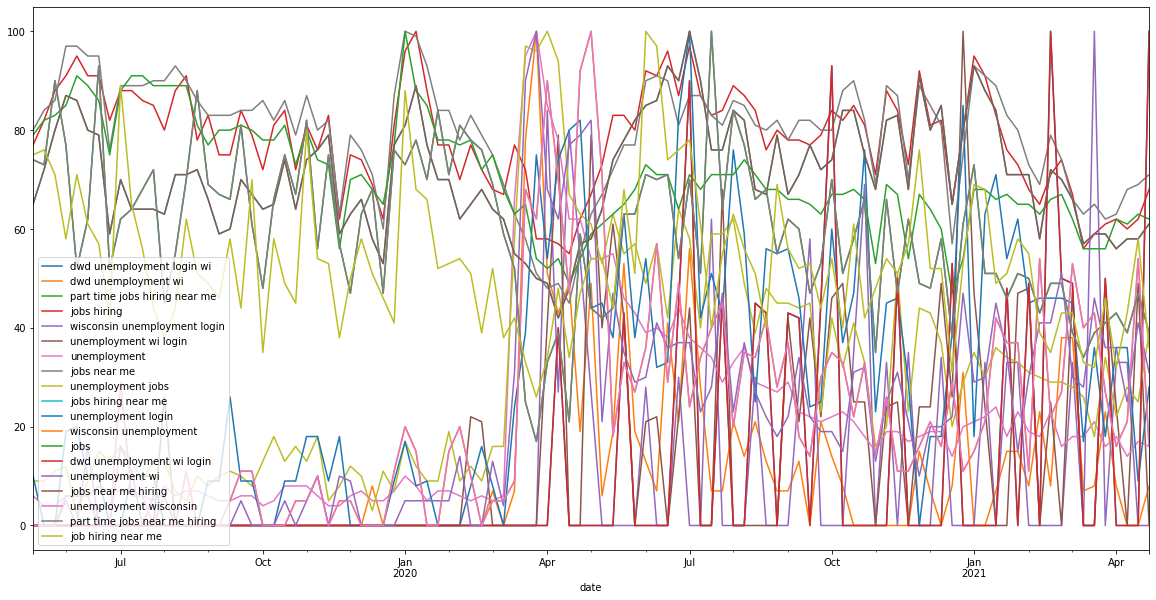

In [30]:
import matplotlib.pyplot as plt

trends_df.plot(figsize=(20, 10))
plt.legend(loc='lower left')
plt.show()

In [31]:
print(trends_df.shape)
print(trends_df.head(2))
print(datetime.datetime.now())


(103, 19)
            dwd unemployment login wi  dwd unemployment wi  \
date                                                         
2019-05-12                          0                    0   
2019-05-19                          0                    0   

            part time jobs hiring near me  jobs hiring  \
date                                                     
2019-05-12                             74           77   
2019-05-19                             73           82   

            wisconsin unemployment login  unemployment wi login  unemployment  \
date                                                                            
2019-05-12                             0                      0             6   
2019-05-19                             0                      0             4   

            jobs near me  unemployment jobs  jobs hiring near me  \
date                                                               
2019-05-12            80                  9    

In [32]:
try:
    out_dir = "./data"
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    trends_df.sort_index()  
    trends_df.to_csv(os.path.join(out_dir, "google_trends.csv"))
except Exception as exc:
    print(exc)
    raise Exception(exc)

In [33]:
import datetime
print(datetime.datetime.now())

2021-05-04 16:24:03.602714
